<a href="https://colab.research.google.com/github/Jeffrowetull/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/Model_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
def load():
  fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
  bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'
  counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True,
                      infer_datetime_format=True)
  
  weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True,
                       infer_datetime_format=True)
  
  daily = counts.resample('d').sum()
  daily['Total'] = daily.sum(axis=1)
  daily = daily[['Total']]
  
  weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
  daily = daily.join(weather[weather_columns], how='inner')
  
  daily['Total_yesterday'] = daily.Total.shift(1)
  daily = daily.drop(index=daily.index[0])
  
  return daily

In [0]:
def split(daily):
  train = daily[:-100]
  test = daily[-100:]
  
  X_train = train.drop(columns="Total")
  y_train = train['Total']
  
  X_test = test.drop(columns ='Total')
  y_test = test.Total
  
  return X_train, X_test, y_train, y_test

In [0]:
def jake_wrangle(X):
  X=X.copy()
  
  days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
  for i, day in enumerate(days):
    X[day] = (X.index.dayofweek == i).astype(float)
    
  from pandas.tseries.holiday import USFederalHolidayCalendar
  cal = USFederalHolidayCalendar()
  holidays = cal.holidays('2012', '2016')
  X = X.join(pd.Series(1,index=holidays, name='holiday'))
  X['holiday'].fillna(0, inplace=True)
  
  def hours_of_daylight(date, axis=23.44, latitude=47.61):
    days = (date - pd.datetime(2000,12,21)).days
    m = (1. - np.tan(np.radians(latitude))
        * np.tan(np.radians(axis) *np.cos(days *2*np.pi/365.25)))
    return 24. *np.degrees(np.arccos(1-np.clip(m,0,2)))/180.
  X['daylight_hrs'] = list(map(hours_of_daylight, X.index))
  
  X['TMIN'] /= 10
  X['TMAX'] /= 10
  
  X['Temp (C)'] = .5 *(X['TMIN']+X['TMAX'])
  
  X['PRCP'] /= 254
  
  X['dry day'] = (X['PRCP'] == 0).astype(int)
  
  X['annual'] =(X.index - X.index[0]).days/365.
  
  return X

In [0]:
data = load()

In [0]:
def wrangle(X):
  X = X.copy()
  X = X.replace(-9999,0)
  X = jake_wrangle(X)
  
  X['PRCP_yesterday'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
  X['Windchill'] = (((X['Temp (C)'
  ] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND'
  ]** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
  X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
  X['TMIN_squared'] = X['TMIN'] **2
  
  months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
  for i, month in enumerate(months):
    X[month] = (X.index.month == i+1).astype(float)
  
  X['weekend_day'] = (X['Sat'] == 1) | (X['Sun'] == 1)
  
  return X

In [0]:
X_train, X_test, y_train, y_test = split(data)

X_train = wrangle(X_train)
X_test = wrangle(X_test)


In [23]:
X_train.head(1)

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,annual,PRCP_yesterday,Windchill,Rl_Cold,TMIN_squared,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,weekend_day
2012-10-04,0.0,0,0,18.9,8.3,65,3521.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,13.6,1,0.0,0.123576,11.462882,7.231732,68.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False


In [27]:

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor



param_distributions = {
    'n_estimators': randint(50,300),
    'max_depth': randint(2,4),
    'criterion': ['mse','mae']
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=24),
    param_distributions = param_distributions,
    n_iter=20,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    cv=3,
    verbose = 10,
    return_train_score=True,
    random_state=24
)

search.fit(X_train.values, y_train.values)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.4s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=24, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbd10c57400>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbd10c57b70>, 'criterion': ['mse', 'mae']},
          pre_dispatch='2*n_jobs', random_state=24, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [33]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, criterion='mae', gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=225,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=24,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
best = search.best_estimator_

In [32]:
pip install eli5

In [36]:
from eli5 import show_weights
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='neg_mean_absolute_error', cv='prefit', n_iter=2,
                                random_state=24)

permuter.fit(X_test.values, y_test)

PermutationImportance(cv='prefit',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, criterion='mae', gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=225,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=24,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
           n_iter=2, random_state=24, refit=True,
           scoring='neg_mean_absolute_error')

In [37]:
feature_names = X_test.columns.tolist()

show_weights(permuter, top=None, feature_names = feature_names)

Weight,Feature
628.8165 ± 81.9741,weekend_day
94.5551 ± 44.8196,Total_yesterday
89.6919 ± 5.9022,TMAX
72.9674 ± 0.7811,PRCP
48.3809 ± 14.1138,Fri
37.3530 ± 0.4989,holiday
26.6161 ± 8.4173,TMIN
21.8535 ± 2.2726,Tue
17.4821 ± 4.6766,Sat
17.1071 ± 8.7156,Mon


In [0]:
print('shape before removal',X_train.shape)
mask = permuter.feature_importances_ >0
features = X_train.columns[mask]
X_train = X_train[features]
X_test = X_test[features]
print('shape after removal',X_train.shape)

In [0]:
X_test = X_test[features]


In [39]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1999s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:    6.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.3s finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=24, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbd10c57400>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbd10c57b70>, 'criterion': ['mse', 'mae']},
          pre_dispatch='2*n_jobs', random_state=24, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [0]:
best = search.best_estimator_

In [53]:
print('train MAE score',-search.best_score_)

train MAE score 270.05159811017916


In [52]:
from sklearn.metrics import mean_absolute_error
y_pred = best.predict(X_test)
print('MAE with test set',mean_absolute_error(y_test,y_pred))

MAE with test set 237.810966796875


(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fbd0a0d3e80>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fbd0a17b400>})

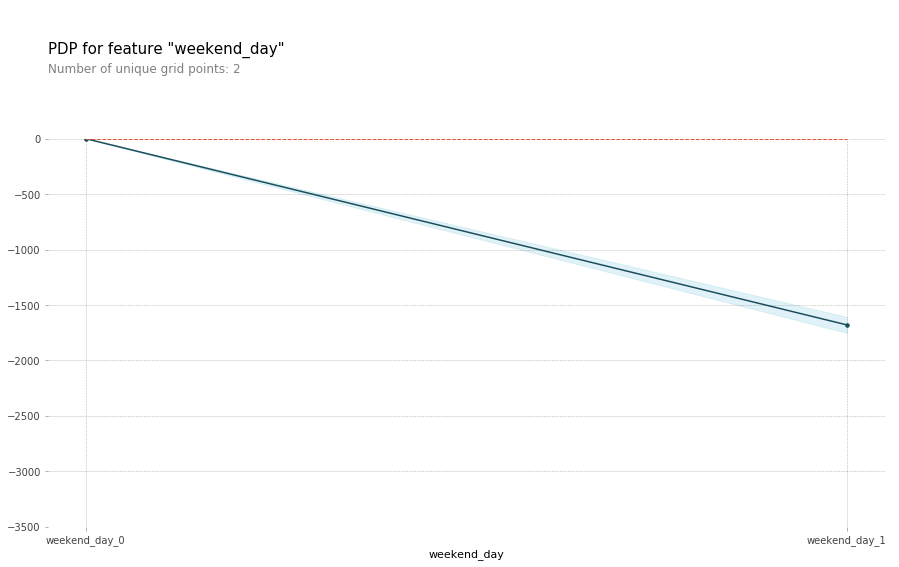

In [54]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'weekend_day'

isolated = pdp_isolate(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    feature = feature

)

pdp_plot(isolated,feature_name=feature)

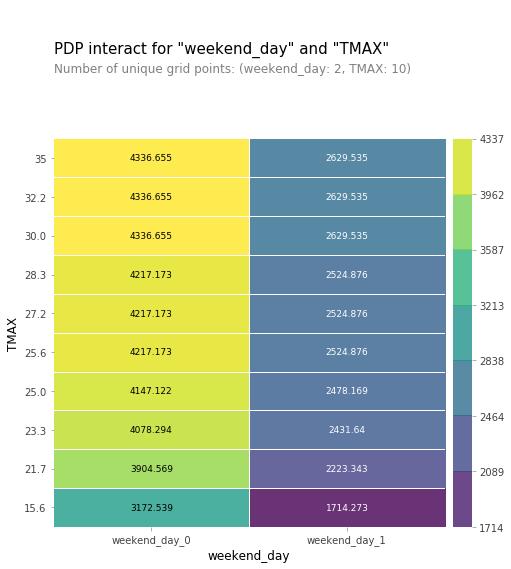

In [55]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['weekend_day', 'TMAX']

interactions = pdp_interact(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)

pdp_interact_plot(interactions, plot_type='grid', feature_names=features);

So is this saying that on hot saturdays, lots of people went across the bridge, but on a hot day on sunday only a little more than half went across?

In [0]:
data=X_test[X_test.index==0]

In [62]:
X_test.head()

,PRCP,TMAX,TMIN,Total_yesterday,Mon,Tue,Wed,Fri,Sat,holiday,daylight_hrs,PRCP_yesterday,Windchill,Rl_Cold,May,weekend_day
2015-05-25,0.0,15.6,11.1,1776.0,1.0,0.0,0.0,0.0,0.0,1.0,15.269661,0.038307,18.657733,2.984593,1.0,False
2015-05-26,0.0,21.7,11.7,1737.0,0.0,1.0,0.0,0.0,0.0,0.0,15.303607,0.000000,26.742639,1.842978,1.0,False
2015-05-27,0.0,24.4,11.7,4254.0,0.0,0.0,1.0,0.0,0.0,0.0,15.336561,0.000000,30.303846,1.214530,1.0,False
2015-05-28,0.0,27.8,12.2,4771.0,0.0,0.0,0.0,0.0,0.0,0.0,15.368497,0.000000,32.730525,1.816375,1.0,False
2015-05-29,0.0,26.1,12.8,5142.0,0.0,0.0,0.0,1.0,0.0,0.0,15.399396,0.000000,30.469309,2.522606,1.0,False


In [61]:
X_test[X_test.index==1]

,PRCP,TMAX,TMIN,Total_yesterday,Mon,Tue,Wed,Fri,Sat,holiday,daylight_hrs,PRCP_yesterday,Windchill,Rl_Cold,May,weekend_day


In [64]:
data=X_test[X_test.index=='2015-05-25']
import shap
shap.initjs()

explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data)
shap.force_plot(explainer.expected_value,shap_values,data)